In [1]:
import os
import shutil
import folium
import numpy as np
import pandas as pd
import pyproj
import math
import datetime
from math import sin,cos,atan,sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
pd.set_option('max_rows',1000)

In [2]:
def get_respondents():
    # 获取所有调查者姓名
    
    global data_path
    raw_path = os.path.join(data_path,'raw data')
    respondents = os.listdir(raw_path)
    return respondents

In [3]:
def copy_gps_diaries():
    # 将轨迹文件夹下的日志复制到专用日志文件夹

    global data_path
    raw_path = os.path.join(data_path,'raw data')
        
    responds = get_respondents()
    for person in responds:
        files = os.listdir(os.path.join(raw_path,person))
        for file in files:
            if 'truth' in file:
                diary_path = os.path.join(data_path,'diaries')
                if not os.path.exists(diary_path): os.makedirs(diary_path)
                shutil.copyfile(os.path.join(raw_path,person,file),os.path.join(diary_path,file))
            else:
                gps_path = os.path.join(data_path,'gps',person)
                if not os.path.exists(gps_path): os.makedirs(gps_path)
                shutil.copyfile(os.path.join(raw_path,person,file),os.path.join(gps_path,file))  

In [4]:
def get_gps():
    # 获取所有轨迹数据索引
    
    all_gps = dict()
    responds = get_respondents()
    for person in responds:
        files = os.listdir(os.path.join(data_path,'gps',person))
        date = list()
        for file in files:
            date.append(file.split('.')[0])
        all_gps[person] = date
    return all_gps

In [5]:
def read_diary(person,date):
    # 读取日志信息
    
    global data_path
    gps_path = os.path.join(data_path,'diaries')
    cols = ['start_time','end_time','purpose','start_place','end_place','mode','lon','lat']
    date = date[:4]+'-'+date[4:6]+'-'+date[6:]
    try:
        with open(os.path.join(gps_path,person+'_truth.txt'),encoding='utf-8') as f:
            df = pd.read_csv(f,header=None,names=cols,dtype={'lon':float,'lat':float})
            df = df[df.start_time.str.contains(date)]
            df.reset_index(drop=True,inplace=True)
            return df

    except FileNotFoundError:
        print('ERROR:文件不存在，检查输入！')

In [6]:
def read_gps(person,date):
    # 读轨迹数据
    
    global data_path
    gps_path = os.path.join(data_path,'gps',person)
    
    try:
        with open(os.path.join(gps_path,date+'.txt')) as f:
            df = pd.read_csv(f,header=None,names=['lon','lat','datetime'],dtype={'lon':float,'lat':float})

        # 噪音剔除
        df = df[df.lat<40]
        df.drop_duplicates(inplace=True)
        df.datetime = df.datetime.apply(pd.to_datetime)
        df.sort_values('datetime',inplace=True)

        # 缺失值
        def fill_missing(df):
            # 插值法补充缺失经纬度；确保时间间隔为1秒
            length = df.index.max()+1
            duration = (df.loc[length-1,'datetime']-df.loc[0,'datetime']).seconds+1
            if length == duration:
                print('{}  {}:\t轨迹数据完整无缺失'.format(person,date))
                df['missing'] = 0
            else:
                print('{}  {}:\t轨迹数据缺失，插值补全'.format(person,date))
                # 根据时间补充索引
                df.set_index('datetime',inplace = True)
                all_time = pd.date_range(df.index.min(),df.index.max(),freq='s')
                df = df.reindex(all_time)
                # 寻找缺失段
                df['missing'] = df.lon.apply(lambda x: 1 if np.isnan(x) else 0)
                df.reset_index(inplace=True)
                df.rename(columns={'index':'datetime'},inplace=True)
                mark = df.missing.diff().fillna(0)
                marks = mark[mark!=0].index.tolist()
                starts = (np.array(mark[mark==1].index)-1).tolist()
                ends = mark[mark==-1].index.tolist()
                missing_num = len(starts)
                for i in range(missing_num):
                    df.loc[starts[i]:ends[i],'lon'] = np.linspace(df.loc[starts[i],'lon'],df.loc[ends[i],'lon'],ends[i]-starts[i]+1)
                    df.loc[starts[i]:ends[i],'lat'] = np.linspace(df.loc[starts[i],'lat'],df.loc[ends[i],'lat'],ends[i]-starts[i]+1)
            return df
        
        df = fill_missing(df) 
        return df
    
    except FileNotFoundError:
        print('ERROR:文件不存在，检查输入！')

In [7]:
def display_track_in_3D(df):
    # 绘制轨迹图
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(df[df.missing==0].lon,df[df.missing==0].lat,df[df.missing==0].index,marker='.',linewidth=0.1,c='b')
    ax.scatter(df[df.missing==1].lon,df[df.missing==1].lat,df[df.missing==1].index,marker='.',linewidth=0.1,c='r')
    ax.set_xlabel('Longitude',fontsize=12)
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Time')

In [8]:
def display_track_in_map(df,sampling_interval=20,zoom_start=12):
    # 在地图上显示轨迹
    
    import folium
    location = [df.lat.mean(),df.lon.mean()]
    maps = folium.Map(location=location,tiles='OpenStreetMap',zoom_start=zoom_start)  # "Stamen Terrain", "Stamen Toner"
    for i in range(0,len(df),sampling_interval):
        folium.CircleMarker([df.loc[i,'lat'], df.loc[i,'lon']],radius=1,color='blue').add_to(maps)
    return maps

In [9]:
def display_track_in_2D(df):
    plt.figure(figsize=(15,5))
    plt.scatter(df[df.missing==0].lon,df[df.missing==0].lat,marker='.',c='b',linewidths=0.1,alpha=0.4)
    plt.scatter(df[df.missing==1].lon,df[df.missing==1].lat,marker='.',c='r',linewidths=0.1,alpha=0.4)

In [10]:
def features(df):
    # velocity, acceleration, heading change rate
    
    df['time'] = df.datetime.apply(lambda r: datetime.time.strftime(r.time(),'%H:%M:%S'))

    def utm_convert(LON,LAT,ZONE):
    # 墨卡托投影
        p = pyproj.Proj(proj='utm',zone=ZONE, ellps='WGS84')  
        xx, yy =p(LON,LAT)
        return [xx, yy]

    gps[['x','y']] = gps[['lon','lat']].apply(lambda r: utm_convert(r.lon,r.lat,ZONE=51),axis=1)  # Shanghai ZONE=51
    df['dist'] = (df[['x','y']].diff().fillna(0)**2).sum(axis=1)**0.5
    df['speed'] = df['dist'].copy()
    df['accelerate'] = df['dist'].diff().fillna(0)
    df['jerk'] = df['accelerate'].diff().fillna(0)
    df['bearing'] = pd.Series(np.arctan((df.y.diff().fillna(0)/df.x.diff().fillna(1)).values))
    df['bear_rate'] = df['bearing'].diff().fillna(0)*180/math.pi
    df.drop('bearing',axis=1,inplace=True)
    return df

In [14]:
def figure_of_features(df,xtick_num=10):
    plt.figure(figsize=(15,9))
    xtick_index = np.floor(np.linspace(df.index.min(),df.index.max(),xtick_num)).astype(int)

    # speed
    plt.subplot(311)
    plt.plot(df.speed,'b-',linewidth=0.5)
    plt.xlim([df.index.min(),df.index.max()])
    plt.ylim([0,40])
    plt.ylabel('Speed (m/s)',fontsize=14)
    plt.xticks(xtick_index, df.loc[xtick_index,'time'].values)

    # acceleration
    plt.subplot(312)
    plt.plot(df.accelerate,'b-',linewidth=0.5)
    plt.xlim([df.index.min(),df.index.max()])
    plt.ylim([-20,20])
    plt.ylabel('Acceleration ($m/s^2$)',fontsize=14)
    plt.xticks(xtick_index, df.loc[xtick_index,'time'].values)

    # heading change rate
    plt.subplot(313)
    plt.plot(df.bear_rate,'b-',linewidth=0.5)
    plt.xlim([df.index.min(),df.index.max()])
    plt.ylim([-180,180])
    plt.ylabel('Bearing Rate',fontsize=14)
    plt.xticks(xtick_index, df.loc[xtick_index,'time'].values)
    ;

''

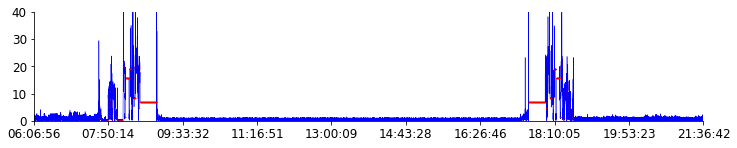

In [16]:
df = gps
xtick_num=10
fig, ax = plt.subplots(figsize=(12,2))
xtick_index = np.floor(np.linspace(df.index.min(),df.index.max(),xtick_num)).astype(int)

# speed
# plt.subplot(311)
plt.plot(df.speed,'b-',linewidth=0.5)
plt.xlim([df.index.min(),df.index.max()])
plt.ylim([0,40])
# plt.ylabel('Speed (m/s)',fontsize=14)
plt.xticks(xtick_index, df.loc[xtick_index,'time'].values,fontsize=12)
plt.yticks(fontsize=12)
plt.plot(df.loc[df.missing==1,'speed'],'r.',markersize=0.1)
# plt.legend(['Normal segment','Missing segment'],loc='upper right',fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.savefig(dpi=600,bbox_inches='tight',filename='C:\\Users\\zhpy\\Desktop\\1.jpg')
;

''

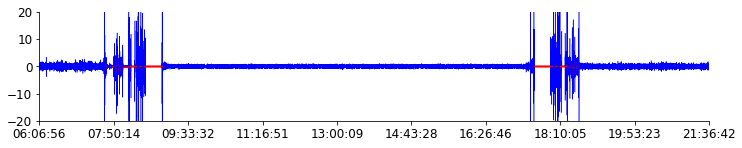

In [44]:
df = gps
fig,ax = plt.subplots(figsize=(12,2))
plt.plot(df.accelerate,'b-',linewidth=0.5)
plt.xlim([df.index.min(),df.index.max()])
plt.ylim([-20,20])
# plt.ylabel('Acceleration ($m/s^2$)',fontsize=14)
plt.xticks(xtick_index, df.loc[xtick_index,'time'].values,fontsize=12)
plt.yticks(fontsize=12)
plt.plot(df.loc[df.missing==1,'accelerate'],'r.',markersize=0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(dpi=600,bbox_inches='tight',filename='C:\\Users\\zhpy\\Desktop\\2.jpg')
;

''

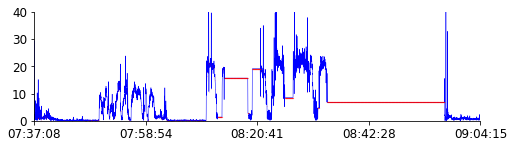

In [17]:
df = gps.loc[5412:10639]
# df = gps.loc[40544:44961]
xtick_num=5
fig,ax = plt.subplots(figsize=(8,2))
xtick_index = np.floor(np.linspace(df.index.min(),df.index.max(),xtick_num)).astype(int)

# speed
# plt.subplot(311)
plt.plot(df.speed,'b-',linewidth=0.5)
plt.xlim([df.index.min(),df.index.max()])
plt.ylim([0,40])
# plt.ylabel('Speed (m/s)',fontsize=14)
plt.xticks(xtick_index, df.loc[xtick_index,'time'].values,fontsize=12)
plt.yticks(fontsize=12)

plt.plot(df.loc[df.missing==1,'speed'],'r.',markersize=0.1)
# plt.legend(['Normal segment','Missing segment'],loc='upper right',fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(dpi=600,bbox_inches='tight',filename='C:\\Users\\zhpy\\Desktop\\3.jpg')
;

''

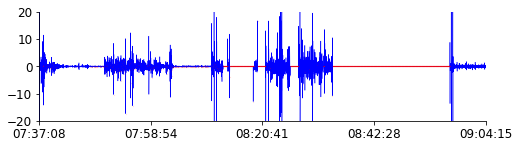

In [46]:
# acceleration
# plt.subplot(312)
fig,ax = plt.subplots(figsize=(8,2))
plt.plot(df.accelerate,'b-',linewidth=0.5)
plt.xlim([df.index.min(),df.index.max()])
plt.ylim([-20,20])
# plt.ylabel('Acceleration ($m/s^2$)',fontsize=14)
plt.xticks(xtick_index, df.loc[xtick_index,'time'].values,fontsize=12)
plt.yticks(fontsize=12)
plt.plot(df.loc[df.missing==1,'accelerate'],'r.',markersize=0.1)
# plt.legend(['Normal segment','Missing segment'],loc='upper right',fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(dpi=600,bbox_inches='tight',filename='C:\\Users\\zhpy\\Desktop\\4.jpg')
;

(array([ 0., 10., 20., 30., 40.]), <a list of 5 Text yticklabel objects>)

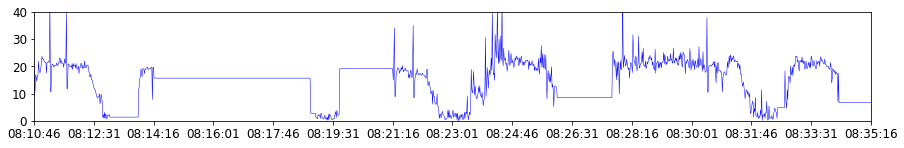

In [81]:
# df = gps.loc[5412:10639]
df = gps.loc[7430:8900]
# df = gps.loc[40544:44961]
xtick_num=15
fig,ax = plt.subplots(figsize=(15,2))
xtick_index = np.floor(np.linspace(df.index.min(),df.index.max(),xtick_num)).astype(int)

# speed
# plt.subplot(311)
plt.plot(df.speed,'b-',linewidth=0.5)
plt.xlim([df.index.min(),df.index.max()])
plt.ylim([0,40])
# plt.ylabel('Speed (m/s)',fontsize=14)
plt.xticks(xtick_index, df.loc[xtick_index,'time'].values,fontsize=12)
plt.yticks(fontsize=12)

### main

zj  20140414:	轨迹数据缺失，插值补全


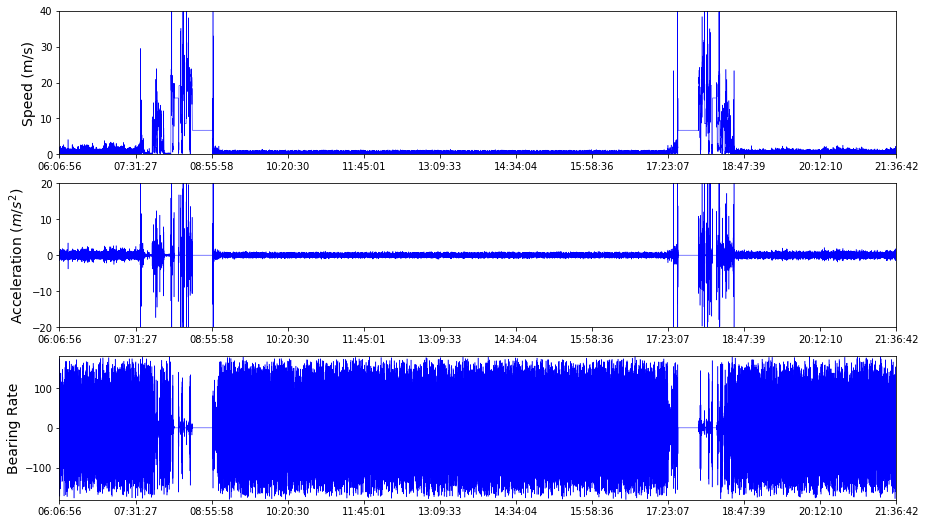

In [15]:
data_path = 'E:\\travel survey\\data'
# copy_gps_diaries()

#  轨迹预处理
person,date = 'zj','20140414'
gps = read_gps(person,date)   # missing:1为缺失点
track = display_track_in_map(gps)
gps = features(gps)   # 求特征
figure_of_features(gps,xtick_num=12) # 显示特征变化

shj  20140415:	轨迹数据缺失，插值补全


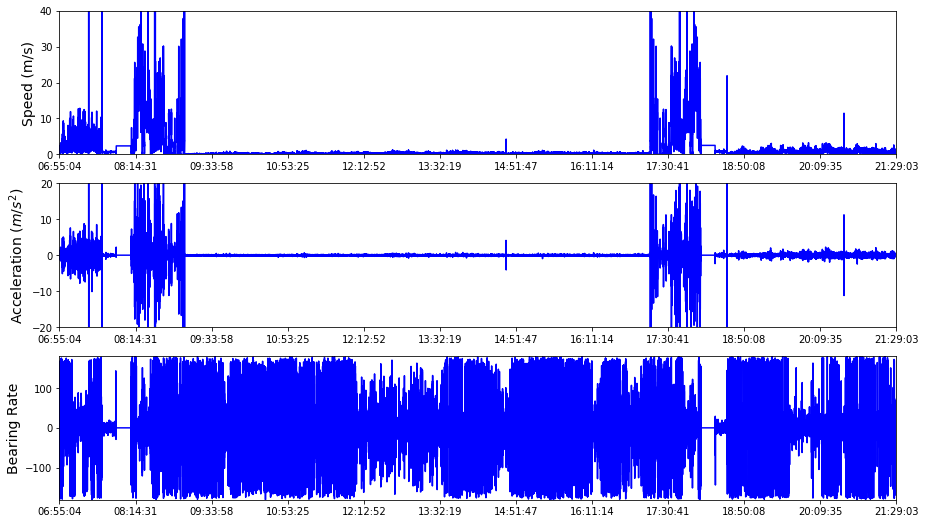

In [12]:
if __name__ == '__main__':
    data_path = 'E:\\travel survey\\data'
    # copy_gps_diaries()
    
    #  轨迹预处理
    person,date = 'shj','20140415'
    gps = read_gps(person,date)   # missing:1为缺失点
    track = display_track_in_map(gps)
    gps = features(gps)   # 求特征
    figure_of_features(gps,xtick_num=12) # 显示特征变化
    diary = read_diary(person,date)